## Bringing `forward-dream` to equilbrium


We can say that `forward-dream` is at genetic equilbrium when the most recent common ancestor of a sample of genomes we collect existed *within* the simulation. In other words, all of the sampled genomes coalesce before reaching the initialisation of the simulation. This ensures we recover the full coalescent tree, it isn't arbitrarily truncated at the initialisation time.

If you fail to equilibriate `forward-dream`, the values of many genetic diversity statistics -- especially those dependent on the deep structure of the tree, like nucleotide diversity, the number of segregating sites, and Tajima's $D$ -- will be incorrect.

Since we do not have an analytical theory of our model, we cannot do this exactly. However, we can assume our model conforms roughly to the neutral coalescent to come up with a reasonable estimate.

There are two parts to this:

1. Choosing a threshold in *coalescent time units*
- These are units of $N_e g$ -- effective population size by generation time
- The threshold should ensure that the $T_{MRCA}$ is *within* the simulation the majority of times
2. Estimating $N_e$ and $g$

In [1]:
import os
import sys
import pandas as pd
import numpy as np

import scipy.integrate as integrate

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.dpi"] = 100

In [2]:
savefig = True

### 1. Choose a threshold in *coalescent time units*

The expected time to the most recent common ancestor for a sample of size $n$ is $E[T_{MRCA}] = 2 (1 - 1/n)$. But we don't just want to capture the average behaviour, we want to capture (as much as possible) the full variance. The probability density over the $T_{MRCA}$ is just a convolution of independent exponentials with rates $\binom{i}{2}$ where $i$ is the number of lineages:

$$ f_{T_{MRCA}}(t) = \sum_{i=2}^{n} \binom{i}{2}e^{-\binom{i}{2}t}\prod_{j=2, j \neq i}^n \frac{\binom{j}{2}}{\binom{j}{2} - \binom{i}{2}} $$

This expression was first derived by Takahata and Nei (1985).

In [3]:
def pdf_tmrca(t, n):
    """
    Return the probability density over the
    time to most recent ancestor (TMRCA) of a sample
    of size `n`
    
    """
    
    res = 0
    
    for i in range(2, n+1):
        
        # Compute the sum constant
        ich = i * (i - 1) / 2
        const = ich * np.exp(-ich * t)
        
        prod = 1
        for j in range(2, n+1):
            if j != i:
                jch = j * (j - 1) / 2
                prod *= jch / (jch - ich)
                
        res += const * prod
        
    return res

In [4]:
def cdf_tmrca(t, n):
    """
    CDF of the TMRCA
    """
    return integrate.quad(lambda t: pdf_tmrca(t, n), 0, t)[0]

In [5]:
pdf_tmrca(1, 20)

0.5011823822301132

In [6]:
ns = [2, 5, 20, 100]
cols = sns.color_palette("Set1", len(ns))

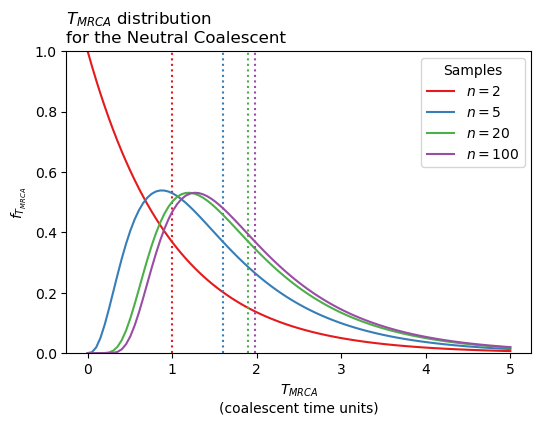

In [7]:
fig, ax = plt.subplots(1, 1)

# Compute
for col, n in zip(cols, ns):
    ts = np.linspace(0, 5, 100)
    ps = np.array([pdf_tmrca(t, n) for t in ts])

    # Plot
    ax.plot(ts, ps, label="$n=$%d" % n, c=col)
    
    # Mean
    mu, err = integrate.quad(lambda t: t*pdf_tmrca(t, n), 0, 100)
    ax.axvline(mu, linestyle='dotted', c=col)

ax.set_ylim(0, 1)
ax.set_xlabel("$T_{MRCA}$\n(coalescent time units)")
ax.set_ylabel("$f_{T_{MRCA}}}$")
ax.set_title("$T_{MRCA}$ distribution\nfor the Neutral Coalescent", 
             loc="left")

ax.legend(title="Samples")

if savefig:
    fig.savefig("../figs/review/tmrca-pdf.png", 
                bbox_inches="tight", pad_inches=0.5)

- The density looks kind of like a gamma distribution
    - which is expected given that a gamma is a convolution of exponentials with the *same* rate
    - Here we have a convolution of exponentials with changing rates
- The expectation converges to 2 as the number of samples increases

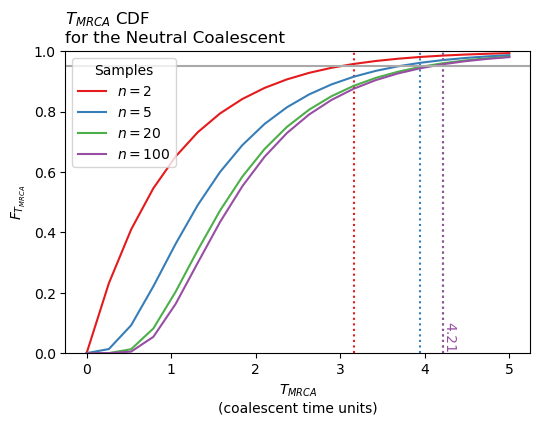

In [8]:
fig, ax = plt.subplots(1, 1)

# Compute
for col, n in zip(cols, ns):
    ts = np.linspace(0, 5, 20)
    ps = np.array([cdf_tmrca(t, n) for t in ts])

    # Plot
    ax.plot(ts, ps, label="$n=$%d" % n, c=col)
    
    # Mean
    thresh = ts[np.where(ps >= 0.95)[0].min()]
    ax.axvline(thresh, ls="dotted", c=col)

    
# Annotate
ax.annotate(xy=(thresh, 0.0), xycoords="data",
            ha="left", va="bottom", rotation=-90,
            c=col,
            text="%.02f" % thresh)
    
ax.set_ylim((0, 1.0))
ax.axhline(0.95, c='darkgrey')
ax.set_xlabel("$T_{MRCA}$\n(coalescent time units)")
ax.set_ylabel("$F_{T_{MRCA}}}$")
ax.set_title("$T_{MRCA}$ CDF\nfor the Neutral Coalescent", 
             loc="left")

ax.legend(title="Samples", loc="upper left")

if savefig:
    fig.savefig("../figs/review/tmrca-cdf.png", 
                bbox_inches="tight", pad_inches=0.5)

- So 95% of the density will be below a threshold of 4.21 coalescent time units

## 2. Estimating $N_e$ and $g$

What is the $N_e$ in `forward-dream`? Recall that the $N_e$ of a population with variable size is the harmonic mean of the two population sizes. In our case, we oscillate between a host and vector population, with the vector population being typically substantially larger. We could roughly formulate the effective size as follows:

$$ N_e = \frac{1}{(\frac{t_h}{t_h + t_v})\frac{1}{N_h} + (\frac{t_v}{t_h + t_v})\frac{1}{N_v}} $$

... where $t_h$ and $t_v$ are the time spent in hosts and vectors, and $N_h$ and $N_v$ are the population sizes of hosts and vectors.

In [9]:
def approx_ne(th, tv, nh, nv):
    """
    An approximated formulation of the Ne
    """
    a = (th / (th + tv)) * (1 / nh)
    b = (tv / (th + tv)) * (1 / nv)
    return 1 / (a + b)

In [10]:
th = 200
tv = 10
nh = 1000
nv = 5000

In [11]:
approx_ne(th, tv, nh, nv)

1039.6039603960396

In [12]:
# These are the ranges used to cover a prevalence from 0.1 - 0.8
nv_range = [1800, 5800]
th_range = [1/0.01389, 1/0.00431]

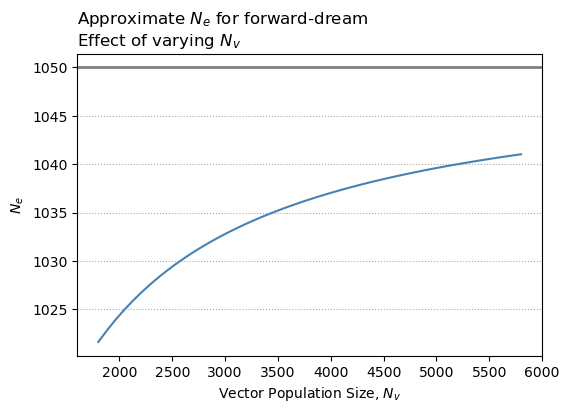

In [13]:
fig, ax = plt.subplots(1, 1)

# Compute
nvs = np.linspace(*nv_range)
nes = approx_ne(th, tv, nh, nvs)

# Plot
ax.plot(nvs, nes, c="steelblue")


ax.axhline(nh * (th + tv) / th, c='grey', ls='solid', lw=2)

ax.grid(axis="y", ls='dotted', c='darkgrey')
ax.set_xlabel("Vector Population Size, $N_v$")
ax.set_ylabel("$N_e$")
ax.set_title("Approximate $N_e$ for forward-dream\nEffect of varying $N_v$", 
             loc="left")

if savefig:
    fig.savefig("../figs/review/ne-vary-nv.png", 
                bbox_inches="tight", pad_inches=0.5)

- We can see that, in general, is that the effective size will be close to that of the smaller, host population. This makes sense -- the majority of coalescent events will occur in this population.
- We can also see that there isn't too pronounced an effect of increasing $N_v$
    - Also quite sensible, $N_v$ is contributing to a very small term in the denominator
    - As that term reaches zero, we will asymtotically approach $N_h ((t_h + t_v) / t_h)$

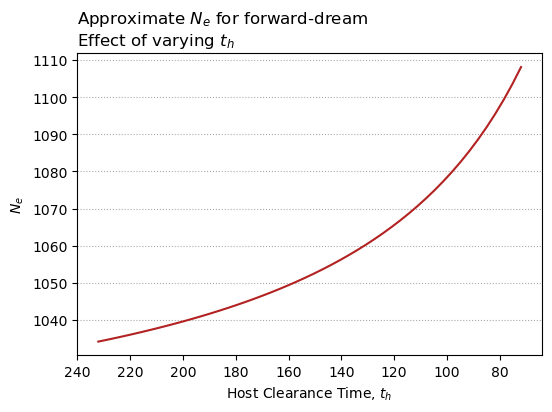

In [14]:
fig, ax = plt.subplots(1, 1)

# Compute
ths = np.linspace(*th_range)
nes = approx_ne(ths, tv, nh, nv)

# Plot
ax.plot(ths, nes, c="firebrick")

# Invert x-axis
ax.invert_xaxis()

ax.grid(axis="y", ls='dotted', c='darkgrey')

ax.set_xlabel("Host Clearance Time, $t_h$")
ax.set_ylabel("$N_e$")
ax.set_title("Approximate $N_e$ for forward-dream\nEffect of varying $t_h$", 
             loc="left")

if savefig:
    fig.savefig("../figs/review/ne-vary-th.png", 
                bbox_inches="tight", pad_inches=0.5)

- This will converge to the vector population size

### Adjacent plot

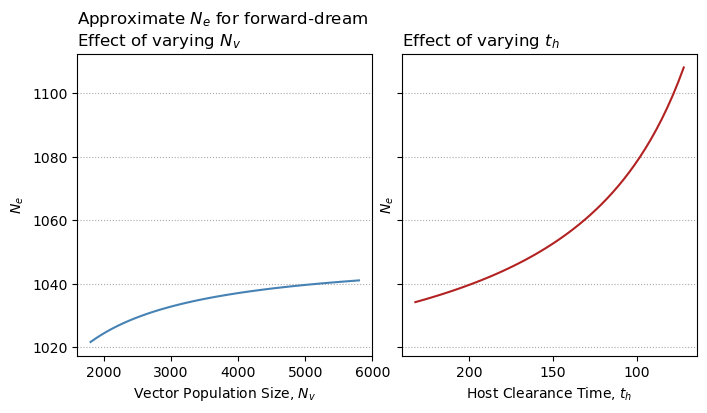

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

# Compute
nvs = np.linspace(*nv_range)
nes = approx_ne(th, tv, nh, nvs)

# Plot
ax[0].plot(nvs, nes, c="steelblue")

ax[0].grid(axis="y", ls='dotted', c='darkgrey')

ax[0].set_xlabel("Vector Population Size, $N_v$")
ax[0].set_ylabel("$N_e$")
ax[0].set_title("Approximate $N_e$ for forward-dream\nEffect of varying $N_v$", 
             loc="left")


# Compute
ths = np.linspace(*th_range)
nes = approx_ne(ths, tv, nh, nv)

# Plot
ax[1].plot(ths, nes, c="firebrick")

# Invert x-axis
ax[1].invert_xaxis()

ax[1].grid(axis="y", ls='dotted', c='darkgrey')

ax[1].set_xlabel("Host Clearance Time, $t_h$")
ax[1].set_ylabel("$N_e$")
ax[1].set_title("Effect of varying $t_h$", 
                loc="left")



if savefig:
    fig.savefig("../figs/review/ne-both.png", 
                bbox_inches="tight", pad_inches=0.5)

- In general then, it is fair to estimate the $N_e$ as approximately equal to the $N_h$.
- In this case, the generation time is the time for a lineage to go from host, to vector, back to host.
- We know that this amount of time should be *less than* the clearance times in host and vector, i.e. less than:
    - $t_h + t_v$

So for our full expression, we can use:

$$ N_e g \simeq N_h (t_h + t_v) $$

This is likely an overestimate of the true value, but that is good -- we would rather be beyond equilibrium than before it.